In [1]:
#Importing standard libraries
import sys
import time
from pathlib import Path
from typing import Optional, cast 

#Importing external modules
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

#Import local modules
module_dir = r"C:\Users\sanvi\Documents\Github\Efficient-Simulation-of-the-Schrodinger-Equation"
sys.path.append(module_dir)
import utils.numerical as numerical
import utils.standard_ho as sho
import utils.visualisation as vis

#Import  QuEvolutio modules
from quevolutio.core.aliases import (  # isort: skip
    RVector,
    GVector,
    CTensors,
    CSRMatrix,
)
from quevolutio.core.domain import QuantumConstants, QuantumHilbertSpace, TimeGrid
from quevolutio.core.tdse import TDSE, Controls, Hamiltonian
from quevolutio.propagators.semi_global import ApproximationBasis, SemiGlobal

In [14]:
class DHOConstants(QuantumConstants):
    """
    Represents the constants of a 1D driven harmonic oscillator in natural
    units through the QuantumConstants interface.

    Attributes
    ----------
    hbar : float
        The reduced Planck constant.
    mass : float
        The mass of the system.
    v0 : float
        The potential of the lattice
    kl : float
        The wavevector of the lattice
    alpha : float
        The lattice depth parameter
    q : float
        The quasimomentum
    band : int
        The band index
    N : int
    ???
    unit_cell : float
        The size of the unit cell.
    num_points : int
        The number of spatial discretization points.
    """

    hbar: float = 1.0
    mass: float = 1.0
    v0: float = 5.0
    kl: float = 1.0
    alpha: float = 10.0
    q: float = 0.0
    band: int = 0
    N: int = 10
    unit_cell: float = np.pi / kl
    num_pts: int = 200
    dims: int = 2*N +1 
constants = DHOConstants()

In [25]:
class OpticalLatticeHamiltonian(Hamiltonian):
    time_dependent: bool = False
    ke_time_dependent: bool = False
    pe_time_dependent: bool = False

    def __init__(
        self, domain: QuantumHilbertSpace, eigenvalue_min: float, eigenvalue_max: float
    ) -> None:
        # Assign attributes.
        self.domain: QuantumHilbertSpace = domain
        self.eigenvalue_min: float = eigenvalue_min
        self.eigenvalue_max: float = eigenvalue_max

        # For static type checking (not runtime required).
        self.domain.constants = cast(DHOConstants, self.domain.constants)

        # Pre-compute the kinetic energy diagonal.
        self._ke_diagonal: RVector = -(domain.momentum_axes[0] ** 2) / (
            2.0 * self.domain.constants.mass
        )
        self._ke_diagonal /= constants.v0 * constants.alpha
        # Pre-compute the lattice potential energy diagonal.
        self._pe_diagonal: RVector = (
            -0.5
            * self.domain.constants.v0
            * np.cos(2 * self.domain.constants.kl * self.domain.position_axes[0])
        )
        self._pe_diagonal /= constants.v0 * constants.alpha

    def __call__(self, state: GVector, controls: Optional[Controls] = None) -> GVector:
            """
            Calculates the action of the Hamiltonian on a state. If the Hamiltonian
            has explicit time dependence, a set of controls should be passed.

            Parameters
            ----------
            state : GVector
                The state being acted on. This should have shape
                (*domain.num_points).
            controls : Optional[Controls]
                The controls which determine the structure of the Hamiltonian. This
                should be passed if the Hamiltonian has explicit time dependence.

            Returns
            -------
            GVector
                The result of acting the Hamiltonian on the state.
            """

            return self.ke_action(state) + self.pe_action(state)
    def ke_action(self, state: GVector, controls: Optional[Controls] = None) -> GVector:
        """
        Calculates the action of the kinetic energy operator on a state. If the
        kinetic energy operator has explicit time dependence, a set of controls
        should be passed.

        Parameters
        ----------
        state : GVector
            The state being acted on. This should have shape
            (*domain.num_points).
        controls : Optional[Controls]
            The controls which determine the structure of the Hamiltonian. This
            should be passed if the kinetic energy operator has explicit time
            dependence.

        Returns
        -------
        GVector
            The result of acting the kinetic energy operator on the state.
        """
       
        return self.domain.position_space(
            self._ke_diagonal * self.domain.momentum_space(state)
        )

    def pe_action(self, state: GVector, controls: Optional[Controls] = None) -> GVector:
        """
        Calculates the action of the potential energy operator on a state. If
        the potential energy operator has explicit time dependence, a set of
        controls should be passed.

        Parameters
        ----------
        state : GVector
            The state being acted on. This should have shape
            (*domain.num_points).
        controls : Optional[Controls]
            The controls which determine the structure of the Hamiltonian. This
            should be passed if the potential energy operator has explicit time
            dependence.

        Returns
        -------
        GVector
            The result of acting the potential energy operator on the state.
        """

        return (
            self._pe_diagonal * state
        )
    
def controls_fn(time: float) -> Controls: 
     """
     Evaluates the controls which determine the structure of the time-dependent
     Schrödinger equation (TDSE) for a 1D driven harmonic oscillator system. In
    this case, this is just the time.

     Parameters
     ----------
    time : float
         The time at which to evaluate the controls.

     Returns
    -------
     Controls
         The controls for the TDSE at the given time.
     """

     return time

In [26]:
def H_builder(alpha, N, q, hbar, k_l, m):
    dims = DHOConstants.dims
    E_r = (hbar**2)*(k_l**2)/(2*m)
    V_0 = alpha*E_r
    main_diag = np.zeros(dims)
    for i in range(-N,N+1):
        main_diag[i+N] = (((2*i+q)/(hbar*k_l))**2*E_r)
    offset_diag = np.full(dims-1, -V_0/4)
    H = np.zeros((dims,dims), dtype= float)
    np.fill_diagonal(H, main_diag)
    np.fill_diagonal(H[1:], offset_diag)
    np.fill_diagonal(H[:,1:], offset_diag)
    return H

hamiltonian = H_builder(DHOConstants.alpha, DHOConstants.N, DHOConstants.q, DHOConstants.hbar, DHOConstants.kl, DHOConstants.mass)
eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)

l = np.arange(-DHOConstants.N, DHOConstants.N+1)
c = eigenvectors[:, DHOConstants.band].astype(complex)

In [27]:
constants: DHOConstants = DHOConstants()
domain: QuantumHilbertSpace = QuantumHilbertSpace(
        num_dimensions=1,
        num_points=np.array([DHOConstants.num_pts]),
        position_bounds=np.array([[-10.0, 10.0]]),
        constants=constants,
    )

#setting up position grid
x_grid = domain.position_axes[0]       # 1D position grid
N = len(x_grid)
dx = x_grid[1] - x_grid[0]                  # grid spacing
domain.momentum_axes = [2*np.pi*np.fft.fftfreq(N, d=dx)]

#set up initial state
m = constants.mass
h_matrix: CSRMatrix = H_builder(DHOConstants.alpha, DHOConstants.N, DHOConstants.q, DHOConstants.hbar, DHOConstants.kl, m)
eigenvalues, eigenvectors = eigsh(h_matrix, k=5, which="SA")
state_idx: int = 0
phase_basis = np.exp(1j * 2 * DHOConstants.kl * l[:, None] * x_grid[None, :])
u = np.sum(c[:, None] * phase_basis, axis=0)
bare_psi = np.exp(1j * DHOConstants.q * x_grid) * u
psi_real = np.real(bare_psi)

#normalise initial state

initial_state: RVector = cast(
        RVector, domain.normalise_state(bare_psi)
    )

eigenvalue_min: float = np.min(eigenvalues)
eigenvalue_max: float = np.max(eigenvalues)

#set up the Hamiltonian
hamiltonian: OpticalLatticeHamiltonian = OpticalLatticeHamiltonian(domain, eigenvalue_min, eigenvalue_max)
tdse: TDSE = TDSE(domain, hamiltonian)
time_domain: TimeGrid = TimeGrid(time_min=0.0, time_max=10.0, num_points=10001)

print("KE diag max abs:", np.max(np.abs(hamiltonian._ke_diagonal)))
print("PE diag max abs:", np.max(np.abs(hamiltonian._pe_diagonal)))




KE diag max abs: 9.771155097188494
PE diag max abs: 0.049999683775201406


In [28]:
#setting up propagator
propagator = SemiGlobal(
tdse,
time_domain,
order_m=10,
order_k=10,
tolerance=1e-5,
approximation=ApproximationBasis.NEWTONIAN,
)
    # Propagate the state.
print("Propagation Start")
start_time: float = time.time()
states: CTensors = propagator.propagate(
    initial_state, diagnostics=True
)
final_time: float = time.time()
print("Propagation Done")
   # Calculate the norms of the states.
norms: RVector = numerical.states_norms(states, domain)

   # Calculate the position expectation values of the states.
states_expectation: RVector = cast(
    RVector,
    np.trapezoid(
        ((np.abs(states) ** 2) * domain.position_axes[0]),
        dx=domain.position_deltas[0],
        axis=1,
      ),
   )

print (states_expectation, states, norms)

Propagation Start
Time Index: 0 	 Iteration: 1
Convergence: 6.33969e-05
Time Index: 0 	 Iteration: 2
Convergence: 0.00000e+00
Time Index: 1 	 Iteration: 1
Convergence: 1.47003e-16
Time Index: 2 	 Iteration: 1
Convergence: 1.73159e-16
Time Index: 3 	 Iteration: 1
Convergence: 1.86023e-16
Time Index: 4 	 Iteration: 1
Convergence: 1.82562e-16
Time Index: 5 	 Iteration: 1
Convergence: 1.99782e-16
Time Index: 6 	 Iteration: 1
Convergence: 1.91292e-16
Time Index: 7 	 Iteration: 1
Convergence: 1.76667e-16
Time Index: 8 	 Iteration: 1
Convergence: 2.11303e-16
Time Index: 9 	 Iteration: 1
Convergence: 1.98040e-16
Time Index: 10 	 Iteration: 1
Convergence: 1.96355e-16
Time Index: 11 	 Iteration: 1
Convergence: 1.71344e-16
Time Index: 12 	 Iteration: 1
Convergence: 1.66007e-16
Time Index: 13 	 Iteration: 1
Convergence: 1.45638e-16
Time Index: 14 	 Iteration: 1
Convergence: 1.73951e-16
Time Index: 15 	 Iteration: 1
Convergence: 1.76353e-16
Time Index: 16 	 Iteration: 1
Convergence: 1.83535e-16
Tim

findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.


FileNotFoundError: [WinError 2] The system cannot find the file specified

findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.


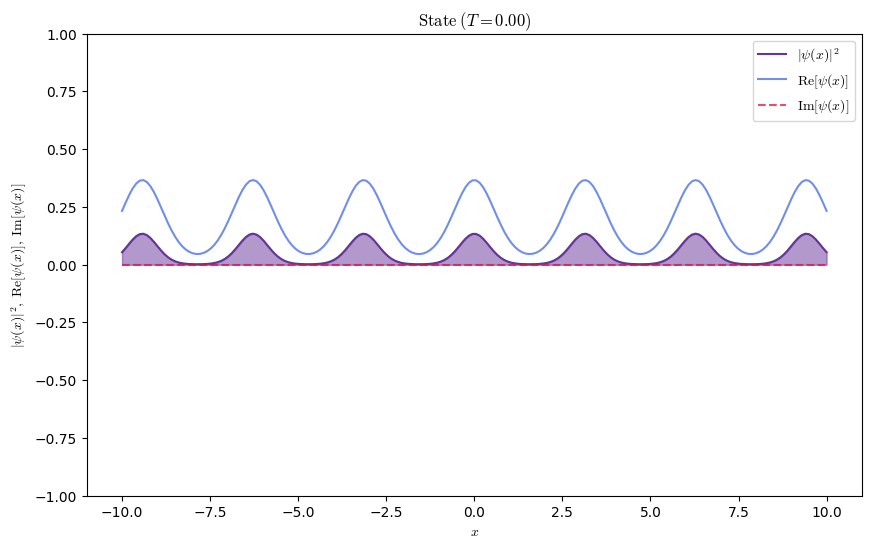

In [ ]:
filename: str = "optical_lattice_1d_testing_n100"

# Create directories for saving data if they do not exist
for folder in (Path("data"), Path("figures"), Path("anims")):
    folder.mkdir(parents=True, exist_ok=True)

# Save the propagated states
np.save(f"data/{filename}.npy", states)

# Plot the propagated states
vis.plot_state_1D(
    states[0],
    domain,
    r"$\text{State} \; (T = 0.00)$",
    f"figures/{filename}_start.png",
)

vis.plot_state_1D(
    states[-1],
    domain,
    rf"$\text{{State}} \; (T = {time_domain.time_axis[-1]:.2f})$",
    f"figures/{filename}_final.png",
)

# Animate the propagated states
#vis.animate_states_1D(states, domain, time_domain, f"anims/{filename}.mp4")